<a href="https://colab.research.google.com/github/dmi3eva/araneae/blob/main/p1_spider_analysis/02_binary_values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mounting

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%cd /content
%cd drive
%cd My\ Drive
%cd PhD
%cd Paper_01

/content
/content/drive
/content/drive/My Drive
/content/drive/My Drive/PhD
/content/drive/My Drive/PhD/Paper_01


In [2]:
DB_PATH = "datasets/spider/database"
SCHEMES_PATH = "datasets/spider/tables.json"

### Loading

In [3]:
import json

In [4]:
import collections
import matplotlib.pyplot as plt
import sqlite3
import os

In [5]:
%matplotlib inline 

### Utils

In [17]:
# legacy
def execution_preprocessing(sql):
  processed_sql = sql.lower()
  if 'from from' in processed_sql:
    processed_sql = processed_sql.replace("from from", "from \"from\"")
  if "%" in processed_sql:
    sql_tokens = sql.split(" ")
    processed_sql_tokens = []
    for _token in sql_tokens:
      if _token[0] == "%":
        _token = f"\"{_token}\""
      processed_sql_tokens.append(_token)
    processed_sql = " ".join(processed_sql_tokens)
  return processed_sql

In [32]:
def execute_request(db_id, sql):
    db = os.path.join(DB_PATH, db_id, db_id + ".sqlite")
    conn = sqlite3.connect(db)
    conn.text_factory = lambda b: b.decode(errors = 'ignore')
    cursor = conn.cursor()   
    try:
        cursor.execute(sql)
        res = cursor.fetchall()
        return res
    except:
        raise ValueError

In [33]:
REQUEST_MASK = """SELECT \"{column}\" FROM \"{table}\"""" 
def get_values(db, table, column):
  # Возвращает значения из столбца данной таблицы
  aim_request = REQUEST_MASK.format(table=table, column=column)
  try:
    response = execute_request(db, aim_request)
    values = [str(_v[0]) for _v in list(response)]
    return values
  except ValueError:
    print()
    print(f"Problem with {column} in {table} (db = {db}). Request: {aim_request}")
    return []

In [10]:
db_ids = os.listdir(DB_PATH)

In [11]:
with open(SCHEMES_PATH) as table_file:
  schemes = json.load(table_file)

tables = {_s['db_id']: _s['table_names_original'] for _s in schemes}

In [12]:
columns = {
    _s['db_id']: {
        _table: [] for _table in _s['table_names_original']
    } for _s in schemes
}
for _scheme in schemes:
  db_id = _scheme['db_id']
  table_names = _scheme['table_names_original']
  for _column in _scheme["column_names_original"]:
    column_name = _column[1]
    table_name = table_names[_column[0]]
    if column_name == '*':
      continue
    columns[db_id][table_name].append(column_name)

In [13]:
def get_db_tables(db):
  return tables[db]

In [14]:
def get_db_columns(db, table):
  return columns[db][table]

### Analysis

In [40]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [70]:
db_amount = len(db_ids)
progress_bar = display(progress(0, db_amount), display_id=True)

def get_db_with_binary_values():
  amounts = {}
  just_amounts = {}
  unique_amounts = {}
  just_unique_amounts = {}
  for ind, _db_id in enumerate(db_ids):
    progress_bar.update(progress(ind, db_amount)) 
    tables = get_db_tables(_db_id)
    for _table in tables:
      columns = get_db_columns(_db_id, _table)
      for _column in columns:
        values = get_values(_db_id, _table, _column)  
        size = len(values)      
        amounts[size] = amounts.get(size, []) + [{
            "db_id": _db_id,
            "table": _table,
            "column": _column,
            "values": values
        }]
        just_amounts[size] = just_amounts.get(size, []) + [{
            "db_id": _db_id,
            "table": _table,
            "column": _column,
            "values_amounts": len(values)
        }]
        unique_values = list(set(values))
        unique_size = len(unique_values)
        unique_amounts[unique_size] = unique_amounts.get(unique_size, []) + [{
            "db_id": _db_id,
            "table": _table,
            "column": _column,
            "values": unique_values
        }]
        just_unique_amounts[unique_size] = just_unique_amounts.get(unique_size, []) + [{
            "db_id": _db_id,
            "table": _table,
            "column": _column,
            "values_amounts": unique_size
        }]
  return just_amounts, amounts, just_unique_amounts, unique_amounts

In [71]:
just_amounts, amounts, just_unique_amounts, unique_amounts = get_db_with_binary_values()

#### Не уникальные

In [ ]:
amounts[2]

["db_id=behavior_monitoring; table=Ref_Address_Types; column=address_type_code; values=['BILL', 'HOME']",
 "db_id=behavior_monitoring; table=Ref_Address_Types; column=address_type_description; values=['Billing', 'Home or Residence']",
 "db_id=cre_Docs_and_Epenses; table=Statements; column=Statement_ID; values=['57', '192']",
 "db_id=cre_Docs_and_Epenses; table=Statements; column=Statement_Details; values=['Open Project', 'Private Project']",
 "db_id=cre_Drama_Workshop_Groups; table=Invoice_Items; column=Invoice_Item_ID; values=['1', '2']",
 "db_id=cre_Drama_Workshop_Groups; table=Invoice_Items; column=Invoice_ID; values=['128', '162']",
 "db_id=cre_Drama_Workshop_Groups; table=Invoice_Items; column=Order_ID; values=['1', '4']",
 "db_id=cre_Drama_Workshop_Groups; table=Invoice_Items; column=Order_Item_ID; values=['5', '6']",
 "db_id=cre_Drama_Workshop_Groups; table=Invoice_Items; column=Product_ID; values=['396', '191']",
 "db_id=cre_Drama_Workshop_Groups; table=Invoice_Items; column=Or

In [ ]:
all_sizes = {_k: len(_v) for _k, _v in amounts.items()}
all_sizes

In [ ]:
size_values = []
last_number = sorted(list(all_sizes.keys()))[-1]
print(last_number)
for i in range(last_number + 1):
  if i not in all_sizes.keys():
    size_values.append(0)
  else:
    size_values.append(all_sizes[i])

510437


(array([510437.]), array([   0, 1000]), <a list of 1 Patch objects>)

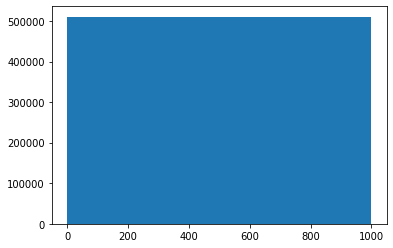

In [ ]:
plt.hist(size_values, bins=[0, 1000])

<BarContainer object of 100 artists>

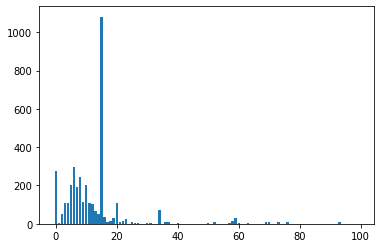

In [ ]:
plt.bar(range(len(size_values[:100])), size_values[:100])

<BarContainer object of 20 artists>

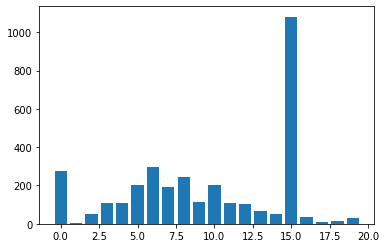

In [ ]:
plt.bar(range(len(size_values[:20])), size_values[:20])

In [ ]:
bin_size = 100000
bin_size_values = [sum(size_values[bin_size*i: bin_size*(i+1)]) for i in range(len(size_values)//bin_size)]

In [ ]:
bin_size_values

[4395, 103, 0, 0, 0]

<BarContainer object of 5 artists>

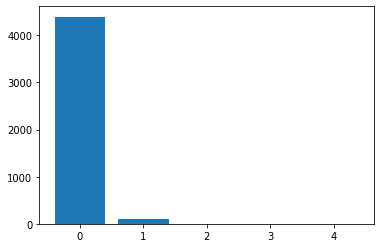

In [ ]:
plt.bar(range(len(bin_size_values)), bin_size_values)

<BarContainer object of 51 artists>

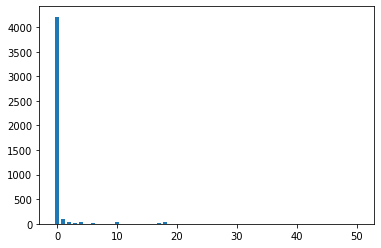

In [ ]:
bin_size = 10000
bin_size_values = [sum(size_values[bin_size*i: bin_size*(i+1)]) for i in range(len(size_values)//bin_size)]
plt.bar(range(len(bin_size_values)), bin_size_values)

<BarContainer object of 50 artists>

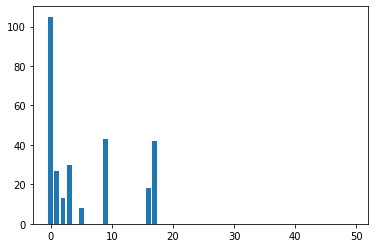

In [ ]:
plt.bar(range(len(bin_size_values[1:])), bin_size_values[1:])

#### Уникальные

In [90]:
def get_list_of_amounts(amount):
  return [ "; ".join([f"{_k}={_v}" for _k, _v in _b.items()]) for _b in unique_amounts[amount]]

In [99]:
list_of_none = get_list_of_amounts(0)

In [98]:
list_of_none

['db_id=academic; table=author; column=aid; values=[]',
 'db_id=academic; table=author; column=homepage; values=[]',
 'db_id=academic; table=author; column=name; values=[]',
 'db_id=academic; table=author; column=oid; values=[]',
 'db_id=academic; table=conference; column=cid; values=[]',
 'db_id=academic; table=conference; column=homepage; values=[]',
 'db_id=academic; table=conference; column=name; values=[]',
 'db_id=academic; table=domain; column=did; values=[]',
 'db_id=academic; table=domain; column=name; values=[]',
 'db_id=academic; table=domain_author; column=aid; values=[]',
 'db_id=academic; table=domain_author; column=did; values=[]',
 'db_id=academic; table=domain_conference; column=cid; values=[]',
 'db_id=academic; table=domain_conference; column=did; values=[]',
 'db_id=academic; table=journal; column=homepage; values=[]',
 'db_id=academic; table=journal; column=jid; values=[]',
 'db_id=academic; table=journal; column=name; values=[]',
 'db_id=academic; table=domain_jou

In [93]:
list_of_unary = get_list_of_amounts(1)

In [94]:
list_of_unary

["db_id=architecture; table=mill; column=notes; values=['Molenechos (Dutch)']",
 "db_id=assets_maintenance; table=Maintenance_Contracts; column=other_contract_details; values=['None']",
 "db_id=assets_maintenance; table=Parts; column=other_part_details; values=['None']",
 "db_id=assets_maintenance; table=Fault_Log; column=other_fault_details; values=['None']",
 "db_id=assets_maintenance; table=Engineer_Visits; column=other_visit_details; values=['None']",
 "db_id=assets_maintenance; table=Part_Faults; column=other_fault_details; values=['None']",
 "db_id=baseball_1; table=manager_award; column=notes; values=['']",
 "db_id=baseball_1; table=college; column=country; values=['USA']",
 "db_id=baseball_1; table=team_half; column=year; values=['1981']",
 "db_id=baseball_1; table=team_half; column=div_win; values=['N']",
 "db_id=behavior_monitoring; table=Addresses; column=line_2; values=['None']",
 "db_id=behavior_monitoring; table=Addresses; column=line_3; values=['None']",
 "db_id=behavior

In [91]:
list_of_binary = get_list_of_amounts(2)

In [92]:
list_of_binary

["db_id=activity_1; table=Student; column=Sex; values=['F', 'M']",
 "db_id=activity_1; table=Faculty; column=Sex; values=['F', 'M']",
 "db_id=allergy_1; table=Student; column=Sex; values=['F', 'M']",
 "db_id=apartment_rentals; table=Apartment_Bookings; column=booking_status_code; values=['Confirmed', 'Provisional']",
 "db_id=apartment_rentals; table=View_Unit_Status; column=available_yn; values=['0', '1']",
 "db_id=architecture; table=architect; column=gender; values=['female', 'male']",
 "db_id=architecture; table=mill; column=type; values=['Bergmolen', 'Grondzeiler']",
 "db_id=assets_maintenance; table=Third_Party_Companies; column=company_type; values=['Maintenance Contractor', 'Supplier']",
 "db_id=assets_maintenance; table=Parts; column=chargeable_yn; values=['0', '1']",
 "db_id=assets_maintenance; table=Parts; column=chargeable_amount; values=['9', '4']",
 "db_id=assets_maintenance; table=Staff; column=gender; values=['0', '1']",
 "db_id=assets_maintenance; table=Assets; column=o

In [ ]:
sorted(unique_amounts.keys())

In [74]:
all_sizes = {_k: len(_v) for _k, _v in unique_amounts.items()}

In [75]:
size_values = []
last_number = sorted(list(all_sizes.keys()))[-1]
print(last_number)
for i in range(last_number + 1):
  if i not in all_sizes.keys():
    size_values.append(0)
  else:
    size_values.append(all_sizes[i])

183978


<BarContainer object of 100 artists>

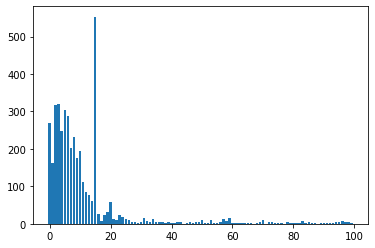

In [76]:
plt.bar(range(len(size_values[:100])), size_values[:100])

<BarContainer object of 20 artists>

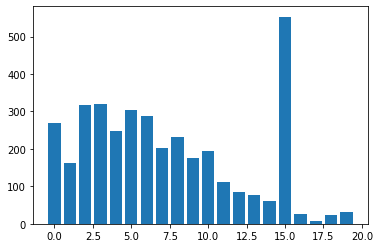

In [77]:
plt.bar(range(len(size_values[:20])), size_values[:20])

In [78]:
bin_size = 100000
bin_size_values = [sum(size_values[bin_size*i: bin_size*(i+1)]) for i in range(len(size_values)//bin_size)]

<BarContainer object of 1 artists>

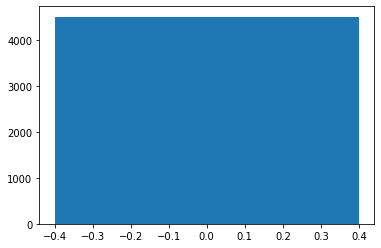

In [79]:
plt.bar(range(len(bin_size_values)), bin_size_values)

In [80]:
bin_size = 10000
bin_size_values = [sum(size_values[bin_size*i: bin_size*(i+1)]) for i in range(len(size_values)//bin_size)]

<BarContainer object of 18 artists>

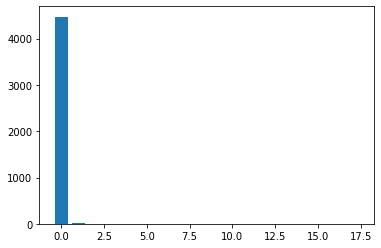

In [81]:
plt.bar(range(len(bin_size_values)), bin_size_values)

#### Defining types of binary values

In [161]:
def define_binary_type_of_column(scheme):
  values = [_v.lower() for _v in scheme['values']]
  column = scheme['column'].lower()
  values_hash = "+".join(sorted(values))
  not_binary_words = ['quantity', 'code', 'stages', 'login']
  coincidence = any([_w in column for _w in not_binary_words])
  
  if values_hash in ["female+male", "f+m", "f", "m", "female", "male"] or 'gender' in column or 'sex' in column:
    return 'binary-gender'
  if values_hash in ["n+y", "no+yes", "n", "y", "no", "yes"] and not coincidence:
    return 'binary-yes-no'  
  if values_hash in ["0+1", "0", "1"] and not coincidence:
    return 'binary-0-1'
  if values_hash in ["false+true", "f+t", "false", "true"] and not coincidence:
    return 'binary-true-false'
  antonyms = ["close+open", "cancelled+completed", "basic+complex", "fail+pass", "nominated+won", "fall+spring", "satisfied+unsatisfied", "organizer+participant", "private+public", "private/methodist+public" , "reported+solved", "leader+researcher", "checking+saving", "check+cleaning", "full+provisional", "bad+good", "grade+purity", "amenity+security", "cytosol+mitochondrion", "primary+secondary", "fail+success", "activitor+inhibitor", "accepted+rejected", 
              "purchase+sale", "pur+sale", "app+reg", "research+sponsor", "initial application+regular", "res+spon", "paper+patent", "published research paper+research pratent", "project researcher+project leader", "friendly+tournament",
              "bill+home", "billing+home or residence", "l+r", "customer+subscriber", "billing+shipping", "cancel+success", "billing+residential", "cancelled+delivered", "completed+part", "no response+order", "payment+refund", "democratic+republican"]
  single_antonyms = [_a.split('+')[0] for _a in antonyms] + [_a.split('+')[1] for _a in antonyms]
  if values_hash in antonyms or len(values) == 1 and values_hash in single_antonyms:
    return 'binary-antonyms'
  if 'details' in column or 'comments' in column or 'notes' in column or 'none' in values or '' in values or 'ok' in values or 'n/a' in values:
    return 'binary-one-many'
  if len(values) == 0:
    return "not-binary"
  if len(values) == 1:
    return "not-binary"
  if len(values) == 2:
    return 'binary-just-two-values' # ???
  return 'binary-other' # ???

In [162]:
binary_classification = {}

for _scheme in unique_amounts[0]:
  binary_type = define_binary_type_of_column(_scheme)
  binary_classification[binary_type] = binary_classification.get(binary_type, []) + [_scheme]

for _scheme in unique_amounts[1]:
  binary_type = define_binary_type_of_column(_scheme)
  binary_classification[binary_type] = binary_classification.get(binary_type, []) + [_scheme]

for _scheme in unique_amounts[2]:
  binary_type = define_binary_type_of_column(_scheme)
  binary_classification[binary_type] = binary_classification.get(binary_type, []) + [_scheme]

In [ ]:
binary_classification

In [163]:
printed_binary_classification = {_t: [";".join([f"{_k}={_v}" for _k, _v in _s.items()]) for _s in _c] for _t, _c in binary_classification.items()}

In [164]:
binary_type = 'not-binary'
print(len(printed_binary_classification[binary_type]))
printed_binary_classification[binary_type]

322


['db_id=academic;table=author;column=aid;values=[]',
 'db_id=academic;table=author;column=homepage;values=[]',
 'db_id=academic;table=author;column=name;values=[]',
 'db_id=academic;table=author;column=oid;values=[]',
 'db_id=academic;table=conference;column=cid;values=[]',
 'db_id=academic;table=conference;column=homepage;values=[]',
 'db_id=academic;table=conference;column=name;values=[]',
 'db_id=academic;table=domain;column=did;values=[]',
 'db_id=academic;table=domain;column=name;values=[]',
 'db_id=academic;table=domain_author;column=aid;values=[]',
 'db_id=academic;table=domain_author;column=did;values=[]',
 'db_id=academic;table=domain_conference;column=cid;values=[]',
 'db_id=academic;table=domain_conference;column=did;values=[]',
 'db_id=academic;table=journal;column=homepage;values=[]',
 'db_id=academic;table=journal;column=jid;values=[]',
 'db_id=academic;table=journal;column=name;values=[]',
 'db_id=academic;table=domain_journal;column=did;values=[]',
 'db_id=academic;tabl

In [152]:
binary_type = 'binary-gender'
print(len(printed_binary_classification[binary_type]))
printed_binary_classification[binary_type]

33


['db_id=imdb;table=actor;column=gender;values=[]',
 'db_id=imdb;table=director;column=gender;values=[]',
 'db_id=imdb;table=producer;column=gender;values=[]',
 'db_id=imdb;table=writer;column=gender;values=[]',
 "db_id=activity_1;table=Student;column=Sex;values=['F', 'M']",
 "db_id=activity_1;table=Faculty;column=Sex;values=['F', 'M']",
 "db_id=allergy_1;table=Student;column=Sex;values=['F', 'M']",
 "db_id=architecture;table=architect;column=gender;values=['female', 'male']",
 "db_id=assets_maintenance;table=Staff;column=gender;values=['0', '1']",
 "db_id=behavior_monitoring;table=Teachers;column=gender;values=['0', '1']",
 "db_id=candidate_poll;table=people;column=Sex;values=['F', 'M']",
 "db_id=club_1;table=Student;column=Sex;values=['F', 'M']",
 "db_id=college_3;table=Student;column=Sex;values=['F', 'M']",
 "db_id=college_3;table=Faculty;column=Sex;values=['F', 'M']",
 "db_id=company_1;table=employee;column=Sex;values=['F', 'M']",
 "db_id=company_1;table=dependent;column=Sex;values=

In [165]:
binary_type = 'binary-yes-no'
print(len(printed_binary_classification[binary_type]))
printed_binary_classification[binary_type]

12


["db_id=baseball_1;table=team_half;column=div_win;values=['N']",
 "db_id=tvshow;table=TV_Channel;column=Pay_per_view_PPV;values=['no']",
 "db_id=baseball_1;table=hall_of_fame;column=inducted;values=['N', 'Y']",
 "db_id=baseball_1;table=manager;column=plyr_mgr;values=['N', 'Y']",
 "db_id=department_management;table=management;column=temporary_acting;values=['Yes', 'No']",
 "db_id=flight_4;table=airlines;column=active;values=['N', 'Y']",
 "db_id=game_1;table=SportsInfo;column=OnScholarship;values=['N', 'Y']",
 "db_id=medicine_enzyme_interaction;table=medicine;column=FDA_approved;values=['Yes', 'No']",
 "db_id=soccer_2;table=Player;column=yCard;values=['yes', 'no']",
 "db_id=soccer_2;table=Tryout;column=decision;values=['yes', 'no']",
 "db_id=tvshow;table=TV_Channel;column=Hight_definition_TV;values=['yes', 'no']",
 "db_id=wine_1;table=appellations;column=isAVA;values=['Yes', 'No']"]

In [154]:
binary_type = 'binary-true-false'
print(len(printed_binary_classification[binary_type]))
printed_binary_classification[binary_type]

8


["db_id=concert_singer;table=singer;column=Is_male;values=['T', 'F']",
 "db_id=debate;table=debate_people;column=If_Affirmative_Win;values=['T', 'F']",
 "db_id=employee_hire_evaluation;table=hiring;column=Is_full_time;values=['T', 'F']",
 "db_id=orchestra;table=show;column=Result;values=['T', 'F']",
 "db_id=party_host;table=party_host;column=Is_Main_in_Charge;values=['T', 'F']",
 "db_id=world_1;table=countrylanguage;column=IsOfficial;values=['T', 'F']",
 "db_id=school_bus;table=school_bus;column=If_full_time;values=['T', 'F']",
 "db_id=wedding;table=people;column=Is_Male;values=['T', 'F']"]

In [155]:
binary_type = 'binary-0-1'
print(len(printed_binary_classification[binary_type]))
printed_binary_classification[binary_type]

19


["db_id=hospital_1;table=On_Call;column=BlockFloor;values=['1']",
 "db_id=insurance_and_eClaims;table=Claims_Processing_Stages;column=Next_Claim_Stage_ID;values=['1']",
 "db_id=products_for_hire;table=Products_Booked;column=returned_yn;values=['1']",
 "db_id=sakila_1;table=film;column=language_id;values=['1']",
 "db_id=apartment_rentals;table=View_Unit_Status;column=available_yn;values=['0', '1']",
 "db_id=assets_maintenance;table=Parts;column=chargeable_yn;values=['0', '1']",
 "db_id=baseball_1;table=fielding_postseason;column=tp;values=['0', '1']",
 "db_id=baseball_1;table=postseason;column=ties;values=['0', '1']",
 "db_id=college_1;table=STUDENT;column=STU_TRANSFER;values=['0', '1']",
 "db_id=dog_kennels;table=Dogs;column=abandoned_yn;values=['0', '1']",
 "db_id=hospital_1;table=Affiliated_With;column=PrimaryAffiliation;values=['0', '1']",
 "db_id=hospital_1;table=Nurse;column=Registered;values=['0', '1']",
 "db_id=hospital_1;table=Room;column=Unavailable;values=['0', '1']",
 "db_id

In [166]:
binary_type = 'binary-antonyms'
print(len(printed_binary_classification[binary_type]))
printed_binary_classification[binary_type]

62


["db_id=customers_campaigns_ecommerce;table=Order_Items;column=item_status_code;values=['good']",
 "db_id=behavior_monitoring;table=Ref_Address_Types;column=address_type_code;values=['BILL', 'HOME']",
 "db_id=behavior_monitoring;table=Ref_Address_Types;column=address_type_description;values=['Billing', 'Home or Residence']",
 "db_id=bike_1;table=trip;column=subscription_type;values=['Customer', 'Subscriber']",
 "db_id=college_2;table=section;column=semester;values=['Spring', 'Fall']",
 "db_id=college_2;table=teaches;column=semester;values=['Spring', 'Fall']",
 "db_id=college_2;table=takes;column=semester;values=['Spring', 'Fall']",
 "db_id=college_3;table=Member_of;column=Appt_Type;values=['Secondary', 'Primary']",
 "db_id=customer_deliveries;table=Actual_Orders;column=order_status_code;values=['Cancel', 'Success']",
 "db_id=customers_and_addresses;table=Customer_Addresses;column=address_type;values=['Billing', 'Residential']",
 "db_id=customers_and_addresses;table=Customer_Orders;colu

In [160]:
binary_type = 'binary-just-two-values'
print(len(printed_binary_classification[binary_type]))
printed_binary_classification[binary_type]

189


["db_id=apartment_rentals;table=Apartment_Bookings;column=booking_status_code;values=['Confirmed', 'Provisional']",
 "db_id=architecture;table=mill;column=type;values=['Bergmolen', 'Grondzeiler']",
 "db_id=assets_maintenance;table=Third_Party_Companies;column=company_type;values=['Maintenance Contractor', 'Supplier']",
 "db_id=assets_maintenance;table=Parts;column=chargeable_amount;values=['9', '4']",
 "db_id=assets_maintenance;table=Fault_Log;column=fault_description;values=['system error', 'failed parts']",
 "db_id=baseball_1;table=all_star;column=league_id;values=['AL', 'NL']",
 "db_id=baseball_1;table=manager_award;column=award_id;values=['TSN Manager of the Year', 'BBWAA Manager of the year']",
 "db_id=baseball_1;table=manager_award_vote;column=award_id;values=['Mgr of the year', 'Mgr of the Year']",
 "db_id=baseball_1;table=manager_award_vote;column=league_id;values=['AL', 'NL']",
 "db_id=baseball_1;table=fielding_postseason;column=league_id;values=['AL', 'NL']",
 "db_id=baseball

In [159]:
binary_type = 'binary-one-many'
print(len(printed_binary_classification[binary_type]))
printed_binary_classification[binary_type]

118


In [ ]:
binary_type = 'binary-other'
print(len(printed_binary_classification[binary_type]))

In [167]:
del binary_classification['not-binary']

In [169]:
del printed_binary_classification['not-binary']

In [168]:
binary_classification.keys()

dict_keys(['binary-gender', 'binary-one-many', 'binary-yes-no', 'binary-antonyms', 'binary-0-1', 'binary-just-two-values', 'binary-true-false'])

### Saving

Не уникальные

In [26]:
with open('datasets/spider/by_amount_of_values/all.json', 'w') as json_file:
    json.dump(amounts, json_file)

In [36]:
with open('datasets/spider/by_amount_of_values/just_amounts.json', 'w') as json_file:
    json.dump(just_amounts, json_file)

In [ ]:
for _size, _requests in amounts.items():
  with open(f'datasets/spider/by_amount_of_values/{str(_size).zfill(6)}.json', 'w') as json_file:
    json.dump(_requests, json_file)

Уникальные

In [82]:
with open('datasets/spider/by_amount_of_unique_values/all.json', 'w') as json_file:
    json.dump(unique_amounts, json_file)

In [83]:
with open('datasets/spider/by_amount_of_unique_values/just_amounts.json', 'w') as json_file:
    json.dump(just_unique_amounts, json_file)

In [84]:
for _size, _requests in unique_amounts.items():
  with open(f'datasets/spider/by_amount_of_unique_values/{str(_size).zfill(6)}.json', 'w') as json_file:
    json.dump(_requests, json_file)

По типам

In [170]:
with open('datasets/araneae/spider_binary.json', 'w') as json_file:
    json.dump(binary_classification, json_file)

In [171]:
with open('datasets/araneae/spider_binary_printable.json', 'w') as json_file:
    json.dump(printed_binary_classification, json_file)

### Zone of tests

In [ ]:
sql = "SELECT count( * ) FROM singer WHERE singer.Is_male = 1"
db_id = "concert_singer"
execute_request(db_id, sql)

[(0,)]

In [ ]:
res = get_values("perpetrator", "people", "Home Town")
res

['Los Angeles, CA',
 'Baton Rouge, LA',
 'Placentia, CA',
 'Westport, CT',
 'Beaver Dam, KY',
 'San Antonio, TX',
 'Denton, TX',
 'Los Angeles, CA',
 'Indianapolis, IN',
 'Altoona, PA',
 'Austin, TX']

In [ ]:
tables = get_db_tables("perpetrator")
tables

['perpetrator', 'people']

In [ ]:
columns = get_db_columns("perpetrator", "people")
columns

['People_ID', 'Name', 'Height', 'Weight', 'Home Town']